In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [11]:
# Constantes físicas
G = 9.81  # Gravedad (m/s²)

In [12]:
# Generación de datos
def calcular_trayectoria(v0, angulo, masa, c, dt=0.01, max_t=60):
    """
    Calcula la trayectoria de un proyectil considerando las ecuaciones diferenciales dadas:
    ax = -c/m * vx
    ay = -g - c/m * vy
    """
    # Convertir ángulo a radianes
    theta = np.radians(angulo)

    # Componentes iniciales de la velocidad
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    # Posiciones iniciales
    x, y = 0, 0

    # Almacenar trayectoria
    xs, ys = [x], [y]

    # Simulación por integración numérica
    t = 0
    while y >= 0 and t < max_t:
        # Aceleraciones basadas en las ecuaciones diferenciales
        ax = -c / masa * vx
        ay = -G - (c / masa) * vy

        # Actualizar velocidades
        vx += ax * dt
        vy += ay * dt

        # Actualizar posiciones
        x += vx * dt
        y += vy * dt

        # Guardar puntos de la trayectoria
        xs.append(x)
        ys.append(y)

        # Incrementar tiempo
        t += dt

    return np.array(xs), np.array(ys)


In [13]:
def generar_datos(n_samples=5000):
    """
    Genera un conjunto de datos basado en las ecuaciones diferenciales dadas.
    """
    # Parámetros aleatorios
    velocidades = np.random.uniform(10, 50, n_samples)  # Velocidad inicial (m/s)
    angulos = np.random.uniform(20, 70, n_samples)  # Ángulo de lanzamiento (grados)
    masas = np.random.uniform(0.1, 5, n_samples)  # Masa (kg)
    constantes_resistencia = np.random.uniform(
        0.1, 1, n_samples
    )  # Constante de resistencia

    # Características de entrada
    X = np.column_stack([velocidades, angulos, masas, constantes_resistencia])
    y = []

    # Generar datos de salida
    for v0, ang, m, c in zip(velocidades, angulos, masas, constantes_resistencia):
        xs, ys = calcular_trayectoria(v0, ang, m, c)
        alcance = xs[-1]  # Última posición en x
        altura_max = max(ys)  # Máxima posición en y
        y.append([alcance, altura_max])

    return np.array(X), np.array(y)

In [14]:
# Prueba de generación de datos
X_data_set, Y_data_set = generar_datos(5000)

# Guardar el conjunto de datos generado
df = pd.DataFrame(
    np.column_stack([X_data_set, Y_data_set]),
    columns=["velocidad", "angulo", "masa", "resistencia", "alcance", "altura"],
)

df.to_csv("proyectil_datos.csv", index=False)

In [15]:
# Comparar trayectorias reales vs predicciones
def comparar_trayectorias(y_test, y_pred):
    """Genera gráficos de comparación entre trayectorias reales y estimadas."""
    plt.figure(figsize=(10, 6))
    plt.scatter(
        y_test[:, 0],
        y_test[:, 1],
        label="Trayectoria Real",
        alpha=0.6,
        color="blue",
    )
    plt.scatter(
        y_pred[:, 0],
        y_pred[:, 1],
        label="Trayectoria Predicha",
        alpha=0.6,
        color="red",
    )
    plt.xlabel("Alcance (m)")
    plt.ylabel("Altura (m)")
    plt.title("Comparación de Trayectorias: Reales vs Predichas")
    plt.legend()
    plt.grid()
    plt.show()

In [16]:
data = pd.read_csv("proyectil_datos.csv")

# Separar características (X) y variables objetivo (y)
# Agregar sin(ángulo) y cos(ángulo) como características
data["sin_angulo"] = np.sin(np.radians(data["angulo"]))
data["cos_angulo"] = np.cos(np.radians(data["angulo"]))

# Actualizar X con las nuevas características
X = data[["velocidad", "sin_angulo", "cos_angulo", "masa", "resistencia"]].values
y = data[["alcance", "altura"]].values


# Escalar los datos
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


def crear_modelo(complejidad="alta", learning_rate=0.001, dropout=False):
    """Crea el modelo con diferentes configuraciones."""

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Entrada explícita

    if complejidad == "alta":
        model.add(Dense(256))
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(BatchNormalization())
        if dropout:
            model.add(Dropout(0.3))

        model.add(Dense(128))
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(BatchNormalization())
        if dropout:
            model.add(Dropout(0.3))

        model.add(Dense(64))
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(BatchNormalization())
        if dropout:
            model.add(Dropout(0.3))

        model.add(Dense(32))
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(BatchNormalization())

    elif complejidad == "media":
        model.add(Dense(128))
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(BatchNormalization())
        model.add(Dense(64))
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(BatchNormalization())
        model.add(Dense(32))
        model.add(LeakyReLU(negative_slope=0.1))

    elif complejidad == "baja":
        model.add(Dense(64, activation="relu"))
        model.add(Dense(32, activation="relu"))

    elif complejidad == "muy_baja":
        model.add(Dense(32, activation="relu"))
        model.add(Dense(16, activation="relu"))

    # Capa de salida
    model.add(Dense(2, activation="linear"))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mae"],
    )
    return model


def entrenar_y_evaluar(
    complejidad="alta", learning_rate=0.001, dropout=False, epochs=1000
):
    model = crear_modelo(
        complejidad=complejidad, learning_rate=learning_rate, dropout=dropout
    )
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0,
    )
    # Evaluar el modelo
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    relative_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    accuracy = 100 - relative_error
    print(
        f"Configuración: Complejidad={complejidad}, LR={learning_rate}, Dropout={dropout}"
    )
    print(f"Error relativo promedio: {relative_error:.2f}%")
    print(f"Precisión del modelo: {accuracy:.2f}%")
    # Graficar curva de aprendizaje

    return history, model


# history1, model1 = entrenar_y_evaluar(
#     complejidad="alta", learning_rate=0.001, dropout=False
# )
# history2, model2 = entrenar_y_evaluar(
#     complejidad="alta", learning_rate=0.0005, dropout=True
# )
# history3, model3 = entrenar_y_evaluar(
#     complejidad="media", learning_rate=0.001, dropout=False
# )


# Graficar curva de aprendizaje
# plt.figure(figsize=(10, 6))
# plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
# plt.plot(history.history["val_loss"], label="Pérdida de Validación")
# plt.xlabel("Épocas")
# plt.ylabel("Pérdida (Loss)")
# plt.title("Curva de Aprendizaje")
# plt.legend()
# plt.grid()
# plt.show()


In [17]:
def calcular_metricas(y_test_original, y_pred_original, history):
    """
    Calcula métricas, grafica curvas de aprendizaje y precisión.
    """
    # Calcular error relativo promedio y precisión
    relative_error = (
        np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    )
    accuracy = 100 - relative_error

    print(f"Error relativo promedio: {relative_error:.2f}%")
    print(f"Precisión del modelo: {accuracy:.2f}%")

    # Graficar comparación de trayectorias
    comparar_trayectorias(y_test_original, y_pred_original)

    # Graficar curva de aprendizaje (pérdida)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["loss"], label="Pérdida de Entrenamiento")
    plt.plot(history.history["val_loss"], label="Pérdida de Validación")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida (Loss)")
    plt.title("Curva de Aprendizaje")
    plt.legend()
    plt.grid()
    plt.show()

    # Graficar curva de precisión (MAE)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["mae"], label="Precisión de Entrenamiento (MAE)")
    plt.plot(history.history["val_mae"], label="Precisión de Validación (MAE)")
    plt.xlabel("Épocas")
    plt.ylabel("Error Absoluto Medio (MAE)")
    plt.title("Curva de Precisión")
    plt.legend()
    plt.grid()
    plt.show()

Prueba 1: Complejidad alta, LR=0.001, sin Dropout
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error relativo promedio: 13.31%
Precisión del modelo: 86.69%


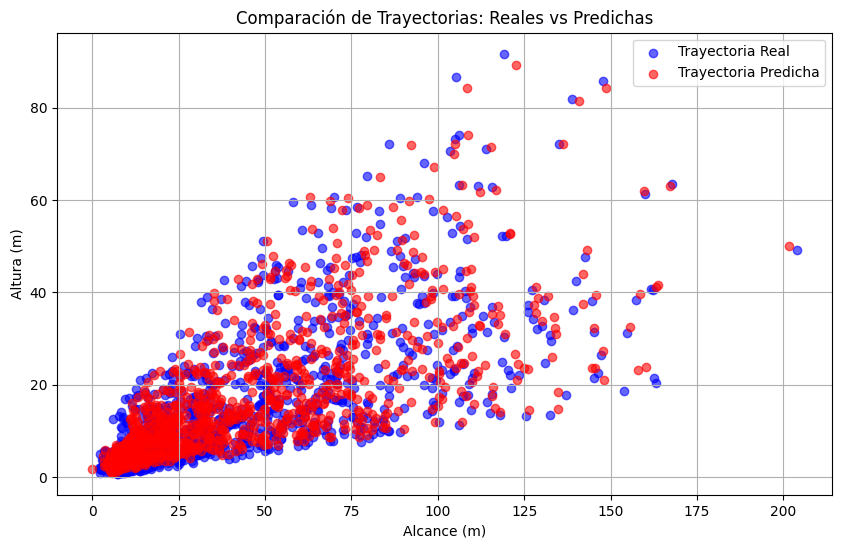

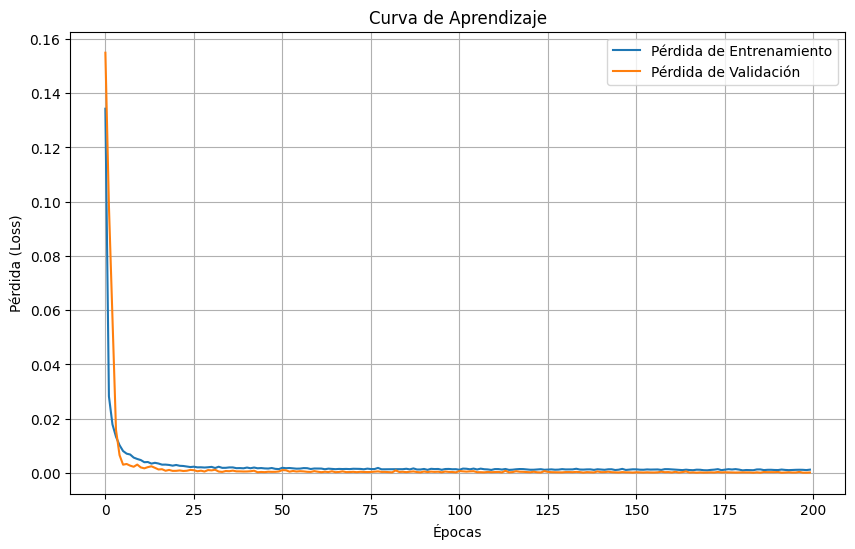

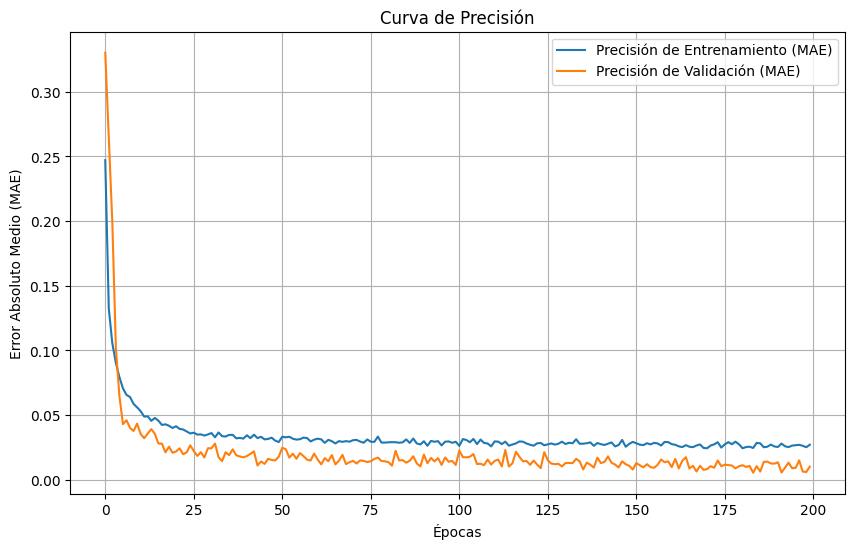

Prueba 2: Complejidad alta, LR=0.0005, con Dropout
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error relativo promedio: 30.36%
Precisión del modelo: 69.64%


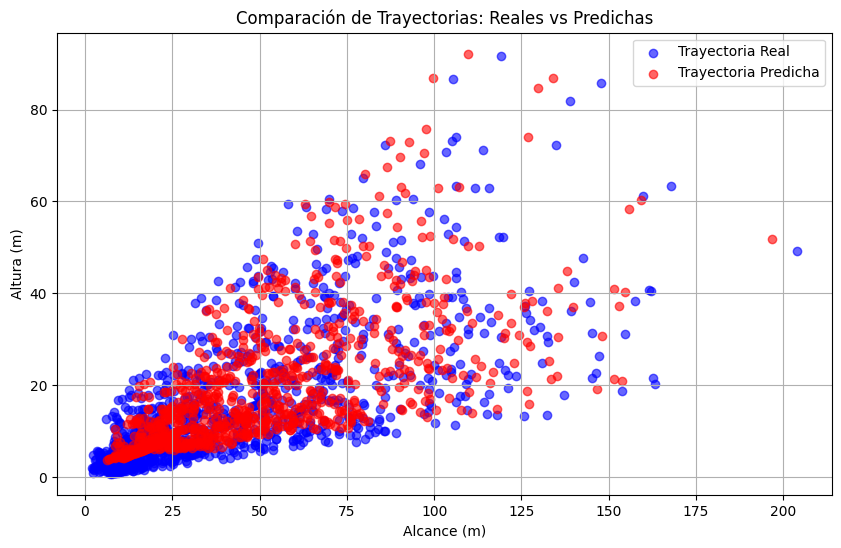

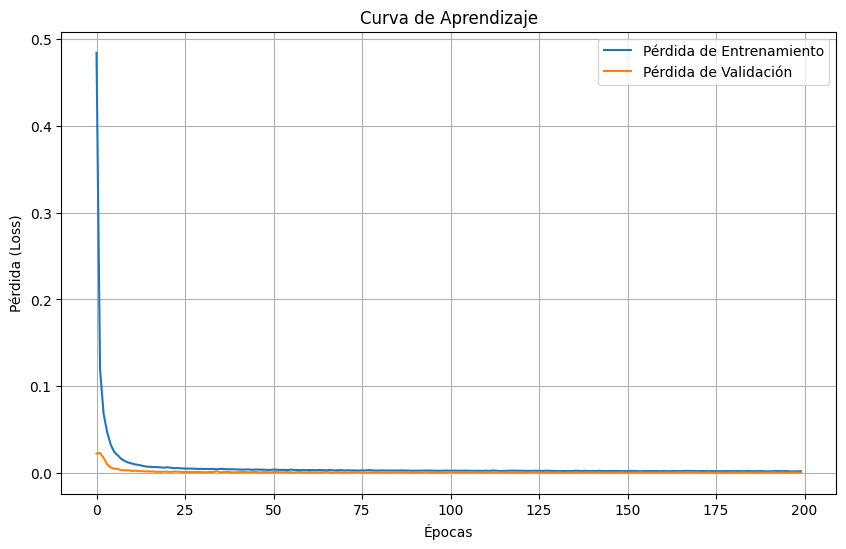

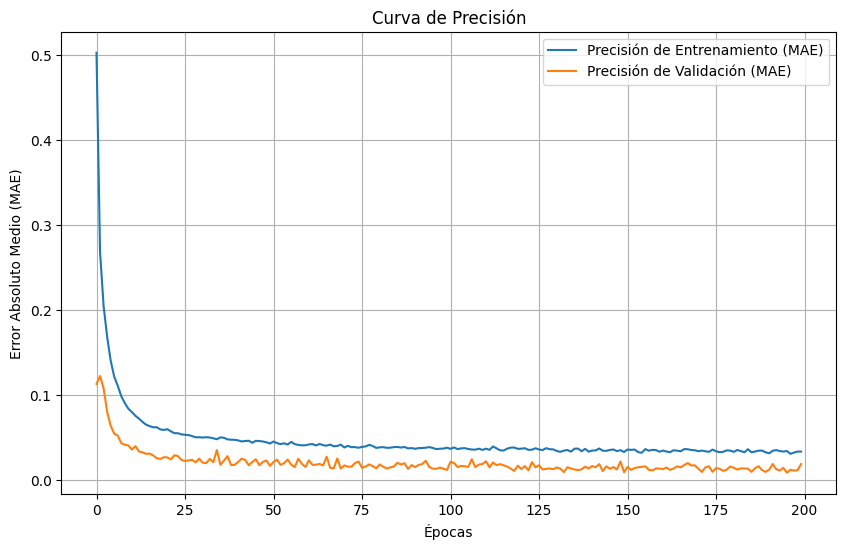

Prueba 3: Complejidad media, LR=0.001, sin Dropout
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error relativo promedio: 8.48%
Precisión del modelo: 91.52%


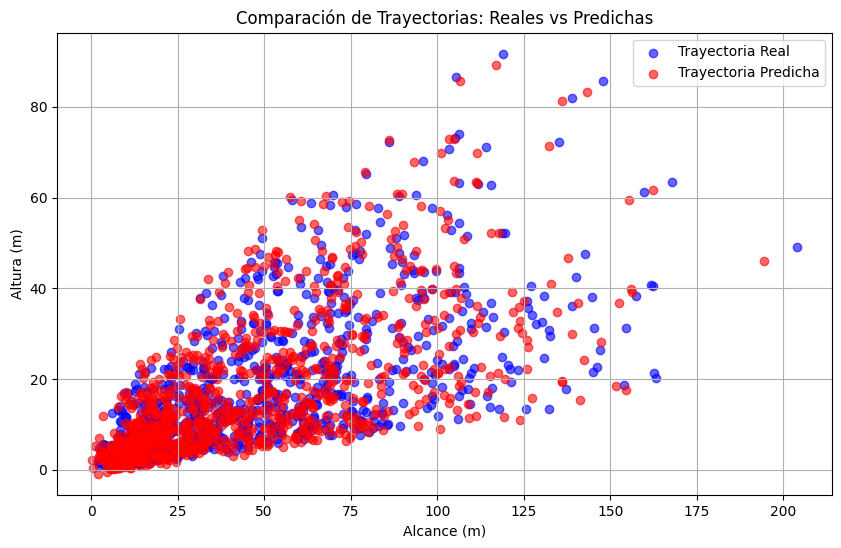

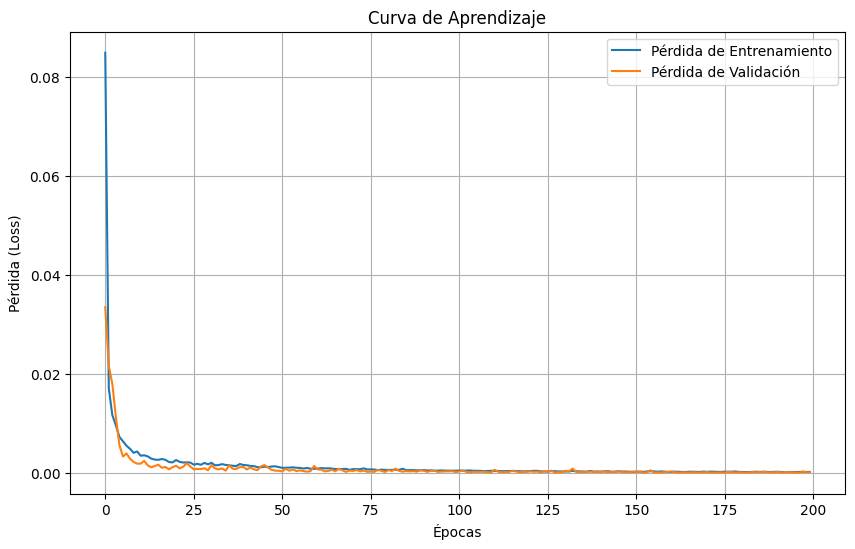

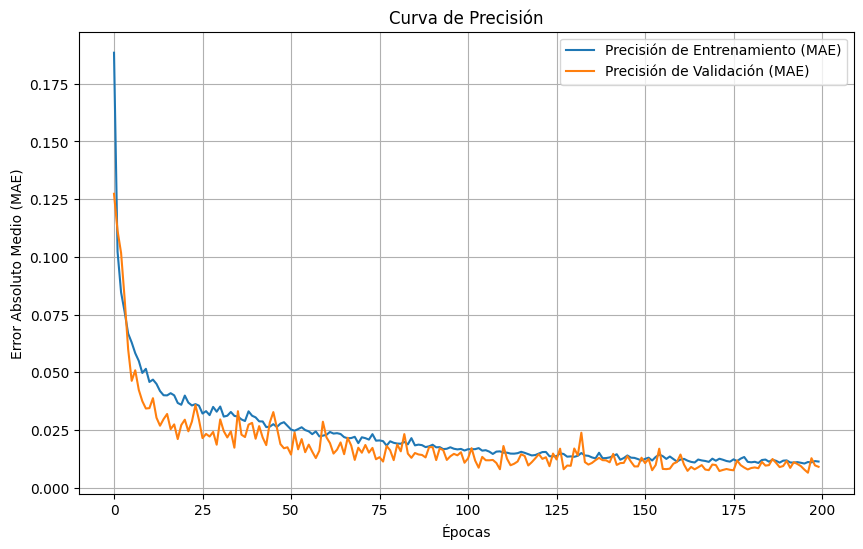

Prueba 3: Complejidad baja, LR=0.001, sin Dropout
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
Error relativo promedio: 3.39%
Precisión del modelo: 96.61%


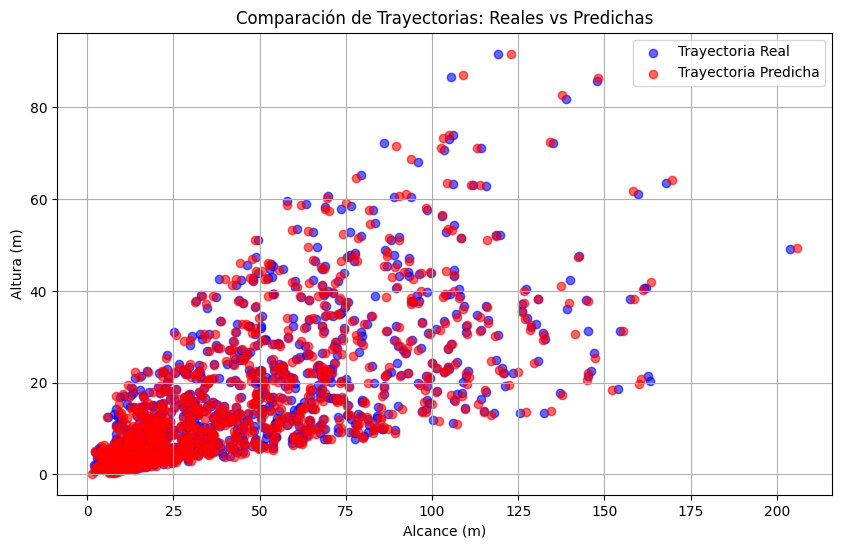

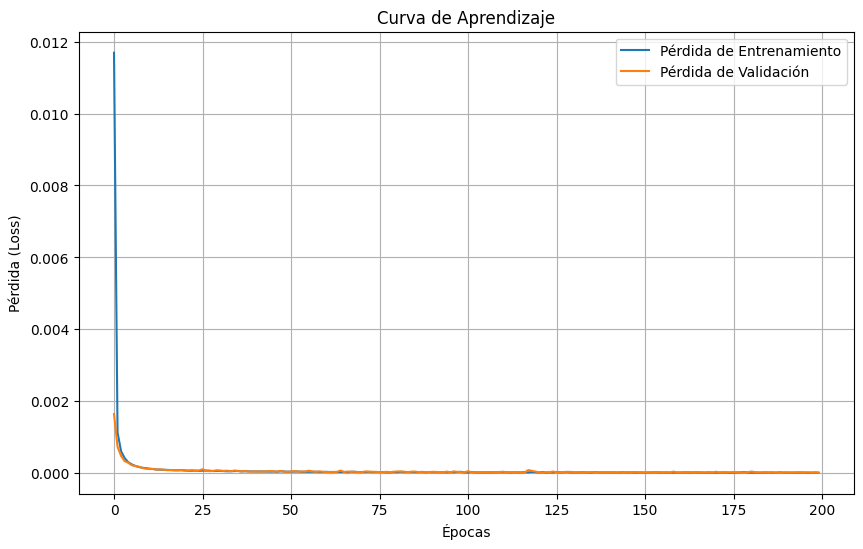

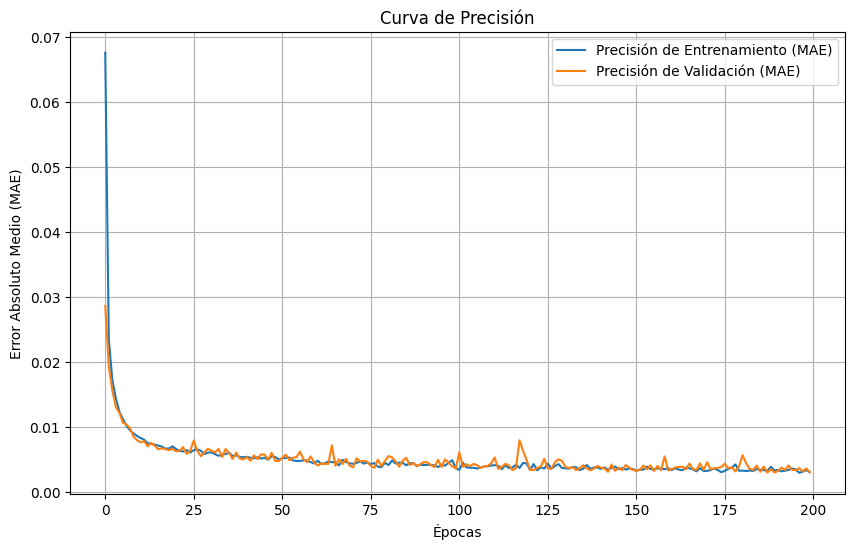

Prueba 3: Complejidad baja, LR=0.001, sin Dropout
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
Error relativo promedio: 5.15%
Precisión del modelo: 94.85%


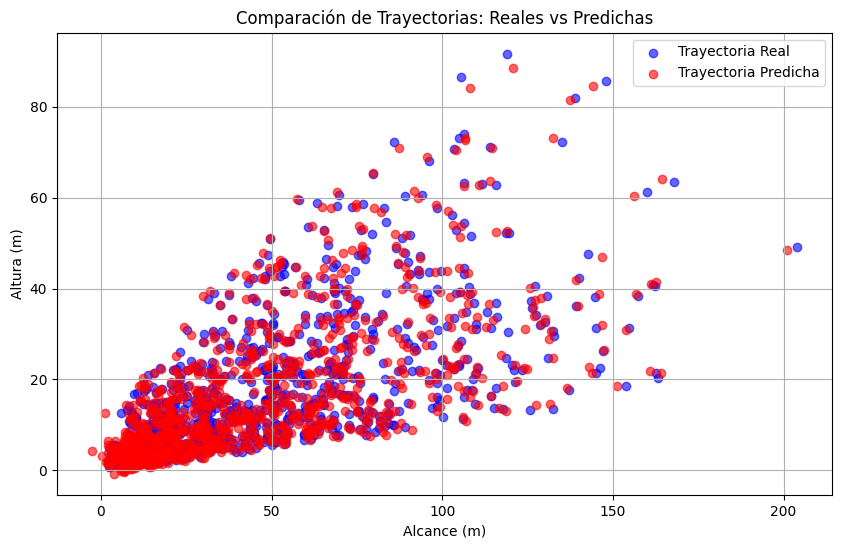

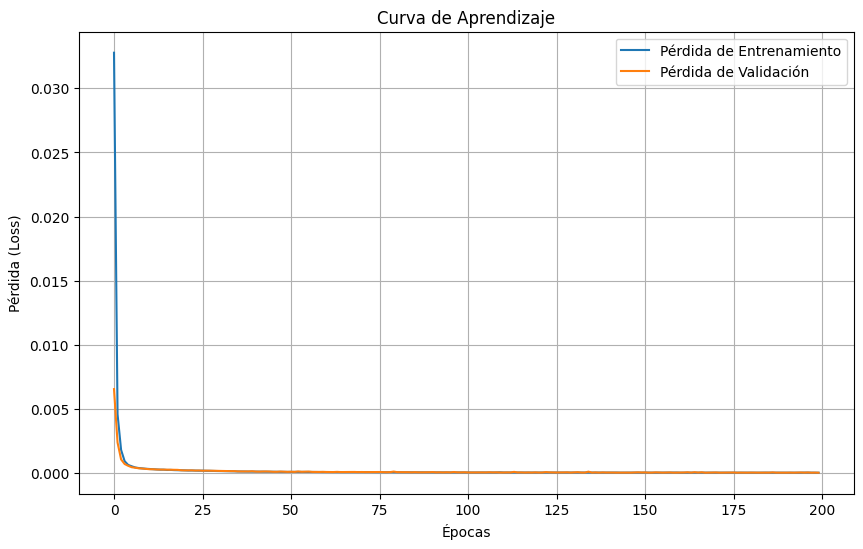

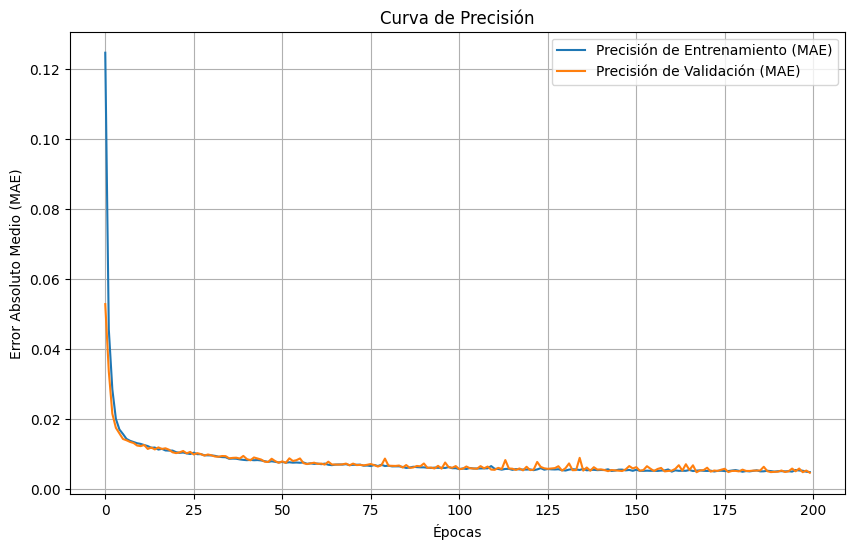

In [ ]:
def ejecutar_prueba(complejidad, learning_rate, dropout, epochs=200):
    """
    Realiza una prueba completa (entrenamiento, evaluación y visualización).
    """
    # Crear el modelo
    model = crear_modelo(
        complejidad=complejidad, learning_rate=learning_rate, dropout=dropout
    )

    # Entrenar el modelo
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0,
    )

    # Evaluar el modelo
    y_pred = model.predict(X_test)
    y_pred_original = scaler_y.inverse_transform(y_pred)
    y_test_original = scaler_y.inverse_transform(y_test)

    # Calcular métricas y graficar resultados
    calcular_metricas(y_test_original, y_pred_original, history)


# Prueba 1: Complejidad alta, LR=0.001, sin Dropout
print("Prueba 1: Complejidad alta, LR=0.001, sin Dropout")
ejecutar_prueba(complejidad="alta", learning_rate=0.001, dropout=False)

# Prueba 2: Complejidad alta, LR=0.0005, con Dropout
print("Prueba 2: Complejidad alta, LR=0.0005, con Dropout")
ejecutar_prueba(complejidad="alta", learning_rate=0.001, dropout=True)

# Prueba 3: Complejidad media, LR=0.001, sin Dropout
print("Prueba 3: Complejidad media, LR=0.001, sin Dropout")
ejecutar_prueba(complejidad="media", learning_rate=0.001, dropout=False)

# Prueba 4: Complejidad baja, LR=0.001, sin Dropout
print("Prueba 3: Complejidad baja, LR=0.001, sin Dropout")
ejecutar_prueba(complejidad="baja", learning_rate=0.001, dropout=False)

# Prueba 4: Complejidad Muy baja, LR=0.001, sin Dropout
print("Prueba 3: Complejidad Muy baja, LR=0.001, sin Dropout")
ejecutar_prueba(complejidad="muy_baja", learning_rate=0.001, dropout=False)
